In [28]:
# library packages
suppressPackageStartupMessages({
  library(Seurat)
  library(tidyverse)
})

In [29]:
for (file in c("ctrl_raw_feature_bc_matrix", "stim_raw_feature_bc_matrix")){
        seurat_data <- Read10X(data.dir = paste0("/Users/jega7008/Desktop/single_cell_rnaseq/data/", file))
        seurat_obj <- CreateSeuratObject(counts = seurat_data, 
                                         min.features = 100, 
                                         project = file)
        assign(file, seurat_obj)
}

In [30]:
# Check the metadata in the new Seurat objects
head(ctrl_raw_feature_bc_matrix@meta.data)
head(stim_raw_feature_bc_matrix@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACATACAATGCC-1,ctrl_raw_feature_bc_matrix,2344,874
AAACATACATTTCC-1,ctrl_raw_feature_bc_matrix,3125,896
AAACATACCAGAAA-1,ctrl_raw_feature_bc_matrix,2578,725
AAACATACCAGCTA-1,ctrl_raw_feature_bc_matrix,3261,979
AAACATACCATGCA-1,ctrl_raw_feature_bc_matrix,746,362
AAACATACCTCGCT-1,ctrl_raw_feature_bc_matrix,3519,866


,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACATACCAAGCT-1,stim_raw_feature_bc_matrix,1221,606
AAACATACCCCTAC-1,stim_raw_feature_bc_matrix,1782,807
AAACATACCCGTAA-1,stim_raw_feature_bc_matrix,1451,605
AAACATACCCTCGT-1,stim_raw_feature_bc_matrix,1549,747
AAACATACGAGGTG-1,stim_raw_feature_bc_matrix,1303,558
AAACATACGCGAAG-1,stim_raw_feature_bc_matrix,5445,1330


In [31]:
# Create a merged Seurat object
merged_seurat <- merge(x = ctrl_raw_feature_bc_matrix, 
                       y = stim_raw_feature_bc_matrix, 
                       add.cell.id = c("ctrl", "stim"))

# Concatenate the count matrices of both samples together
merged_seurat <- JoinLayers(merged_seurat)                            

In [32]:
# Check that the merged object has the appropriate sample-specific prefixes
head(merged_seurat@meta.data)
tail(merged_seurat@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA
,<chr>,<dbl>,<int>
ctrl_AAACATACAATGCC-1,ctrl_raw_feature_bc_matrix,2344,874
ctrl_AAACATACATTTCC-1,ctrl_raw_feature_bc_matrix,3125,896
ctrl_AAACATACCAGAAA-1,ctrl_raw_feature_bc_matrix,2578,725
ctrl_AAACATACCAGCTA-1,ctrl_raw_feature_bc_matrix,3261,979
ctrl_AAACATACCATGCA-1,ctrl_raw_feature_bc_matrix,746,362
ctrl_AAACATACCTCGCT-1,ctrl_raw_feature_bc_matrix,3519,866


,orig.ident,nCount_RNA,nFeature_RNA
,<chr>,<dbl>,<int>
stim_TTTGCATGCGACAT-1,stim_raw_feature_bc_matrix,620,295
stim_TTTGCATGCTAAGC-1,stim_raw_feature_bc_matrix,1641,545
stim_TTTGCATGGGACGA-1,stim_raw_feature_bc_matrix,1233,518
stim_TTTGCATGGTGAGG-1,stim_raw_feature_bc_matrix,1084,469
stim_TTTGCATGGTTTGG-1,stim_raw_feature_bc_matrix,818,432
stim_TTTGCATGTCTTAC-1,stim_raw_feature_bc_matrix,1104,438


In [33]:
# Explore merged metadata
View(merged_seurat@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA
,<chr>,<dbl>,<int>
ctrl_AAACATACAATGCC-1,ctrl_raw_feature_bc_matrix,2344,874
ctrl_AAACATACATTTCC-1,ctrl_raw_feature_bc_matrix,3125,896
ctrl_AAACATACCAGAAA-1,ctrl_raw_feature_bc_matrix,2578,725
ctrl_AAACATACCAGCTA-1,ctrl_raw_feature_bc_matrix,3261,979
ctrl_AAACATACCATGCA-1,ctrl_raw_feature_bc_matrix,746,362
ctrl_AAACATACCTCGCT-1,ctrl_raw_feature_bc_matrix,3519,866
ctrl_AAACATACCTGGTA-1,ctrl_raw_feature_bc_matrix,3328,1137
ctrl_AAACATACCTGTAG-1,ctrl_raw_feature_bc_matrix,484,281
ctrl_AAACATACGATGAA-1,ctrl_raw_feature_bc_matrix,1991,650


In [34]:
# Add number of genes per UMI for each cell to metadata
merged_seurat$log10GenesPerUMI <- log10(merged_seurat$nFeature_RNA) / log10(merged_seurat$nCount_RNA)

# Compute percent mito ratio
merged_seurat$mitoRatio <- PercentageFeatureSet(object = merged_seurat, pattern = "^MT-")
merged_seurat$mitoRatio <- merged_seurat@meta.data$mitoRatio / 100

# Create metadata dataframe
metadata <- merged_seurat@meta.data

# Add cell IDs to metadata
metadata$cells <- rownames(metadata)

# Create sample column
metadata$sample <- NA
metadata$sample[which(str_detect(metadata$cells, "^ctrl_"))] <- "ctrl"
metadata$sample[which(str_detect(metadata$cells, "^stim_"))] <- "stim"

# Rename columns
metadata <- metadata %>%
        dplyr::rename(seq_folder = orig.ident,
                      nUMI = nCount_RNA,
                      nGene = nFeature_RNA)

# Add metadata back to Seurat object
merged_seurat@meta.data <- metadata

In [35]:
# Filter out low-quality cells using selected thresholds - these will change with the experiment
filtered_seurat <- subset(merged_seurat, 
                          subset= nUMI >= 500 &
                          nGene >= 250 &
                          log10GenesPerUMI > 0.80 & 
                          mitoRatio < 0.20)

In [36]:
# Extract counts
counts <- GetAssayData(object = filtered_seurat, slot = "counts")

# Output a logical matrix specifying for each gene whether or not there are more than zero counts per cell
nonzero <- counts > 0
# Sums all TRUE values and returns TRUE if more than 100 TRUE values per gene
keep_genes <- Matrix::rowSums(nonzero) >= 100

# Only keeping those genes expressed in more than 100 cells
filtered_counts <- counts[keep_genes, ]
# Reassign to filtered Seurat object
filtered_seurat <- CreateSeuratObject(filtered_counts, meta.data = filtered_seurat@meta.data)

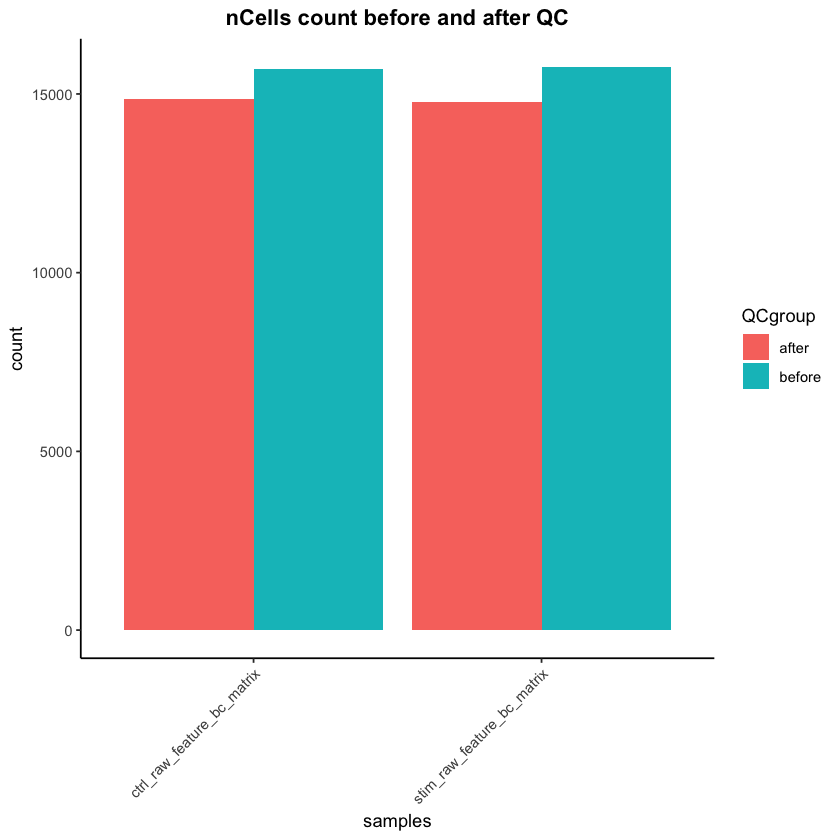

In [37]:
# Save filtered subset to new metadata
metadata_clean <- filtered_seurat@meta.data

# to see a drop in filtering cells:

met_before <- data.frame(unclass(table(metadata$seq_folder)))
met_before$QCgroup <- "before"
met_before$cell<- rownames(met_before)
names(met_before)[1] <- 'count'

met_after <- data.frame(unclass(table(metadata_clean$seq_folder)))
met_after$QCgroup <- "after"
met_after$cell<- rownames(met_after)
names(met_after)[1] <- 'count'
# count
cell_count <- data.frame(rbind(met_before, met_after))

                                
# visualization :
cell_count %>% ggplot(aes(x=cell, y=count, fill=QCgroup)) + 
  geom_bar(stat="identity", position=position_dodge()) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
  theme(plot.title = element_text(hjust=0.5, face="bold")) +
  xlab("samples") +
  ggtitle("nCells count before and after QC")

In [38]:
# Normalize the counts
seurat_phase <- NormalizeData(filtered_seurat)

# Load cell cycle markers
load("/Users/jega7008/Desktop/single_cell_rnaseq/data/cycle.rda")

# Score cells for cell cycle
seurat_phase <- CellCycleScoring(seurat_phase, 
                                 g2m.features = g2m_genes, 
                                 s.features = s_genes)

Normalizing layer: counts

Warning message:
"The following features are not present in the object: RAD51, MCM2, CLSPN, CDC45, CDC6, POLA1, RAD51AP1, HELLS, E2F8, GINS2, BRIP1, DSCC1, DTL, CDCA7, CENPU, CHAF1B, RRM2, EXO1, CCNE2, TYMS, UHRF1, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: NCAPD2, ANLN, HMMR, GTSE1, AURKA, TPX2, BIRC5, CDCA3, TTK, ECT2, CENPA, CDC20, NEK2, HJURP, DLGAP5, PIMREG, TOP2A, PSRC1, CDCA8, KIF23, KIF11, CENPE, GAS2L3, KIF2C, NUF2, MKI67, CCNB2, CDC25C, CKAP2L, BUB1, CDK1, UBE2C, AURKB, CDCA2, not searching for symbol synonyms"


In [39]:
# Identify the most variable genes
seurat_phase <- FindVariableFeatures(seurat_phase, 
                     selection.method = "vst",
                     nfeatures = 2000, 
                     verbose = FALSE)


# Check quartile values for mitoRatio, we will use this variable later to mitigate the unwanted sources of variation in the dataset
summary(seurat_phase@meta.data$mitoRatio)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01438 0.01993 0.02139 0.02669 0.14464 

Centering and scaling data matrix

PC_ 1 
Positive:  C15orf48, CST3, TYROBP, FCER1G, SOD2, TYMP, ANXA5, TIMP1, KYNU, LGALS3 
	   FTL, FCN1, CD63, CTSB, LGALS1, APOBEC3A, IGSF6, LYZ, S100A4, ANXA2 
	   CCL2, SPI1, PSAP, NPC2, NINJ1, CD68, S100A11, CTSL, MAFB, IDO1 
Negative:  CCR7, TMSB4X, LTB, TRBC1, ITM2A, TRAT1, RGCC, IL32, IL7R, CCL5 
	   NKG7, ALOX5AP, TSC22D3, GZMB, GNLY, CST7, CD27, CREM, PASK, SNHG8 
	   TMEM243, BIRC3, CD8A, MYC, GPR171, SH2D2A, CD8B, GZMH, ADTRP, KLRD1 
PC_ 2 
Positive:  ISG15, IFIT3, IFIT1, ISG20, LY6E, TNFSF10, IFIT2, MX1, IFI6, RSAD2 
	   CXCL10, OAS1, CXCL11, IFITM3, MT2A, USP18, IRF7, OASL, IDO1, TNFSF13B 
	   IFI35, IL1RN, EPSTI1, IFITM2, SAMD9L, CCL8, GBP1, NT5C3A, PLSCR1, APOBEC3A 
Negative:  CXCL8, CLEC5A, CD14, S100A8, VCAN, IER3, IL1B, MARCKSL1, PID1, CD9 
	   PLAUR, S100A9, OSM, THBS1, PHLDA1, SLC7A11, PPIF, GAPT, AC245128.3, INSIG1 
	   MCEMP1, ENG, MGST1, CXCL3, OLR1, LIMS1, SMIM25, GAPDH, PFN1, FTH1 
PC_ 3 
Positive:  NKG7, GNLY, CCL5, GZMB, PRF

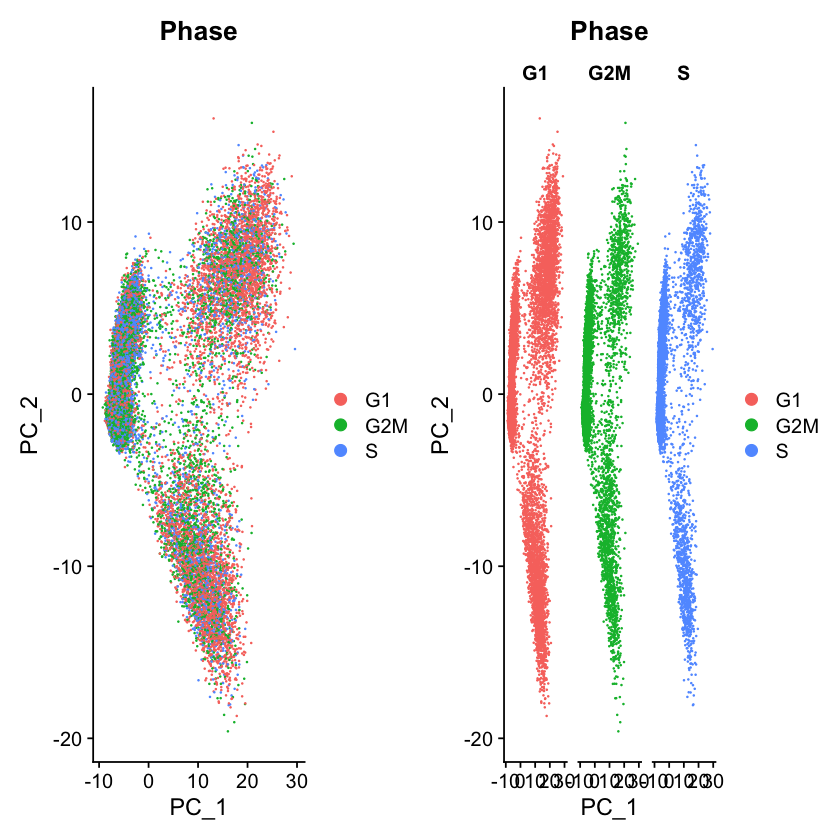

In [40]:
# Scale the counts
seurat_phase <- ScaleData(seurat_phase)

# Perform PCA
seurat_phase <- RunPCA(seurat_phase)

# Plot the PCA colored by cell cycle phase
no_split <- DimPlot(seurat_phase,
        reduction = "pca",
        group.by= "Phase")
        
with_split <- DimPlot(seurat_phase,
        reduction = "pca",
        group.by= "Phase",
        split.by= "Phase")

no_split + with_split

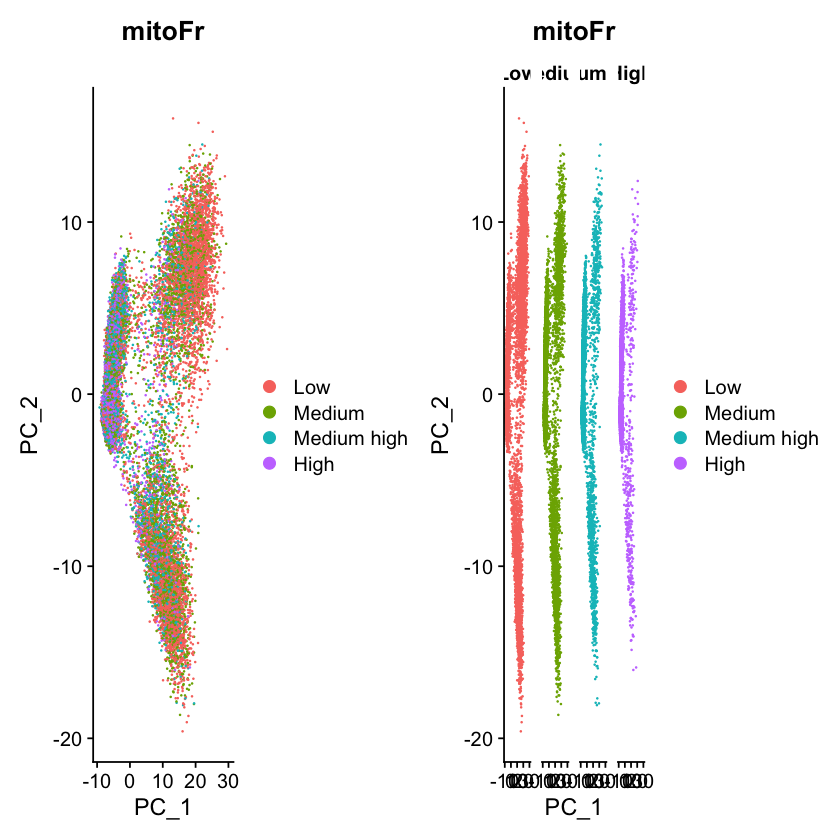

In [41]:
# Turn mitoRatio into categorical factor vector based on quartile values
seurat_phase@meta.data$mitoFr <- cut(seurat_phase@meta.data$mitoRatio, 
                   breaks=c(-Inf, 0.01438, 0.01993, 0.02669, Inf), 
                   labels=c("Low","Medium","Medium high", "High"))
                   
# Plot the PCA colored by mitochondrial expression
no_split <- DimPlot(seurat_phase,
        reduction = "pca",
        group.by= "mitoFr")
        
with_split <- DimPlot(seurat_phase,
        reduction = "pca",
        group.by= "mitoFr",
        split.by= "mitoFr")
        
no_split + with_split

In [42]:
# Split seurat object by condition to perform cell cycle scoring and SCT on all samples
split_seurat <- SplitObject(seurat_phase, split.by = "sample")

options(future.globals.maxSize = 4000 * 1024^2)

for (i in 1:length(split_seurat)) {
    split_seurat[[i]] <- SCTransform(split_seurat[[i]], vars.to.regress = c("mitoRatio"), vst.flavor = "v2")
    }

gc()
# Select the most variable features to use for integration
integ_features <- SelectIntegrationFeatures(object.list = split_seurat, 
                                            nfeatures = 3000)

gc()
# Prepare the SCT list object for integration
split_seurat <- PrepSCTIntegration(object.list = split_seurat, 
                                   anchor.features = integ_features)

gc()
# Run PCA on Split Seurat Object
split_seurat <- lapply(X = split_seurat, FUN = RunPCA, features = integ_features)

# Find best buddies - can take a while to run
gc()
integ_anchors <- FindIntegrationAnchors(object.list = split_seurat, 
                                        normalization.method = "SCT",
                                        reduction = "rpca",
                                        anchor.features = integ_features)

gc()
seurat_integrated <- IntegrateData(anchorset = integ_anchors, 
                                   normalization.method = "SCT")

# Rejoin the layers in the RNA assay that we split earlier
seurat_integrated[["RNA"]] <- JoinLayers(seurat_integrated[["RNA"]])
                                

Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Variance stabilizing transformation of count matrix of size 9786 by 14847

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = 

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,5320776,284.2,8501621,454.1,NA,8501621,454.1
Vcells,519513675,3963.6,1196458380,9128.3,131072,1196458295,9128.3


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,5322331,284.3,8501621,454.1,NA,8501621,454.1
Vcells,519520052,3963.7,1196458380,9128.3,131072,1196458295,9128.3


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,5328377,284.6,8501621,454.1,NA,8501621,454.1
Vcells,519534628,3963.8,1196458380,9128.3,131072,1196458295,9128.3


PC_ 1 
Positive:  FTL, TIMP1, CXCL8, C15orf48, FTH1, CCL2, S100A8, FCER1G, S100A9, TYROBP 
	   LYZ, S100A4, CD63, LGALS3, HLA-DRA, ACTB, LGALS1, ANXA5, CD14, S100A11 
	   SOD2, S100A10, SAT1, CXCL3, TYMP, ANXA2, PLAUR, CST3, IL1B, PSAP 
Negative:  RPL3, RPL13, RPS6, RPS18, RPL10, RPL21, RPL13A, RPS2, PABPC1, TRAC 
	   PTMA, RPS4X, RPS3, TRBC1, RPS27, LTB, GNLY, RPS14, CCR7, RPL32 
	   RPS15A, CCL5, RPS19, RPL34, TRBC2, RPL7, RPS5, IGKC, RPS27A, GIMAP7 
PC_ 2 
Positive:  GNLY, CCL5, NKG7, GZMB, FGFBP2, GZMH, CST7, APOBEC3G, CLIC3, KLRD1 
	   GZMA, PRF1, CCL4, CTSW, CHST12, HOPX, RARRES3, HLA-A, C1orf21, APMAP 
	   OASL, CXCR3, AOAH, HLA-B, C12orf75, HLA-C, CD247, KLRC1, SH2D2A, CD7 
Negative:  IGKC, IGHM, CD74, HLA-DRA, CD79A, HLA-DRB1, HLA-DQA1, HLA-DPA1, IGLC2, HLA-DPB1 
	   HLA-DQB1, CCR7, MS4A1, CD83, ID3, HERPUD1, CD79B, RPL13, EEF1A1, RPL18A 
	   RPS5, IGHD, HLA-DMA, RPS6, RPL8, RPS18, RPL10, PABPC1, RPS2, LTB 
PC_ 3 
Positive:  FTL, PABPC1, TRAC, S100A8, CCL2, LTB, S100A9, GIMAP7

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,5329027,284.7,8501621,454.1,NA,8501621,454.1
Vcells,519638891,3964.6,1196458380,9128.3,131072,1196458295,9128.3


Computing within dataset neighborhoods

Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 9204 anchors



,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,5347414,285.6,8501621,454.1,NA,8501621,454.1
Vcells,519755183,3965.5,1196458380,9128.3,131072,1196458295,9128.3


[1] 1


Warning message:
"Different cells and/or features from existing assay SCT"
Warning message:
"Layer counts isn't present in the assay object; returning NULL"


[1] 2


Warning message:
"Different cells and/or features from existing assay SCT"
Warning message:
"Layer counts isn't present in the assay object; returning NULL"
Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Layer counts isn't present in the assay object; returning NULL"
Warning message:
"Assay integrated changing from Assay to SCTAssay"
Warning message:
"Layer counts isn't present in the assay object; returning NULL"
Warning message:
"Different cells and/or features from existing assay SCT"


PC_ 1 
Positive:  FTL, TIMP1, C15orf48, CCL2, FTH1, CXCL8, FCER1G, TYROBP, S100A8, LGALS3 
	   CD63, S100A4, SOD2, HLA-DRA, LYZ, ANXA5, LGALS1, SAT1, CXCL10, TYMP 
	   ACTB, S100A11, S100A9, CST3, CCL8, S100A10, CTSL, ANXA2, CD14, CTSB 
Negative:  RPL3, RPS6, RPL13, RPL10, RPS18, RPS2, RPL13A, PABPC1, RPL21, RPS4X 
	   LTB, RPS3, TRBC1, RPS14, TRAC, RPL7, CCR7, RPL34, RPL32, PTMA 
	   RPS27, RPS15A, RPS19, RPS27A, RPS3A, RPS5, RPS12, RPL31, TRBC2, SARAF 
PC_ 2 
Positive:  GNLY, CCL5, GZMB, NKG7, CST7, APOBEC3G, PRF1, FGFBP2, GZMH, CLIC3 
	   KLRD1, GZMA, CHST12, CTSW, HOPX, HLA-A, CCL4, RARRES3, HLA-B, HLA-C 
	   C1orf21, AOAH, C12orf75, APMAP, CXCR3, CD247, KLRC1, LDHA, OASL, TNFRSF18 
Negative:  CD74, IGHM, IGKC, HLA-DRA, CCR7, CD79A, RPL13, EEF1A1, PABPC1, HLA-DRB1 
	   RPS18, RPS6, LTB, RPL10, RPL32, RPS2, RPS12, RPS5, RPL18A, RPL34 
	   RPS23, RPL11, RPL13A, RPS8, HLA-DQB1, RPS13, RPL10A, RPL9, HLA-DQA1, RPL8 
PC_ 3 
Positive:  CD74, IGKC, HLA-DRA, IGHM, HLA-DRB1, HLA-DPA1, HLA-DQ

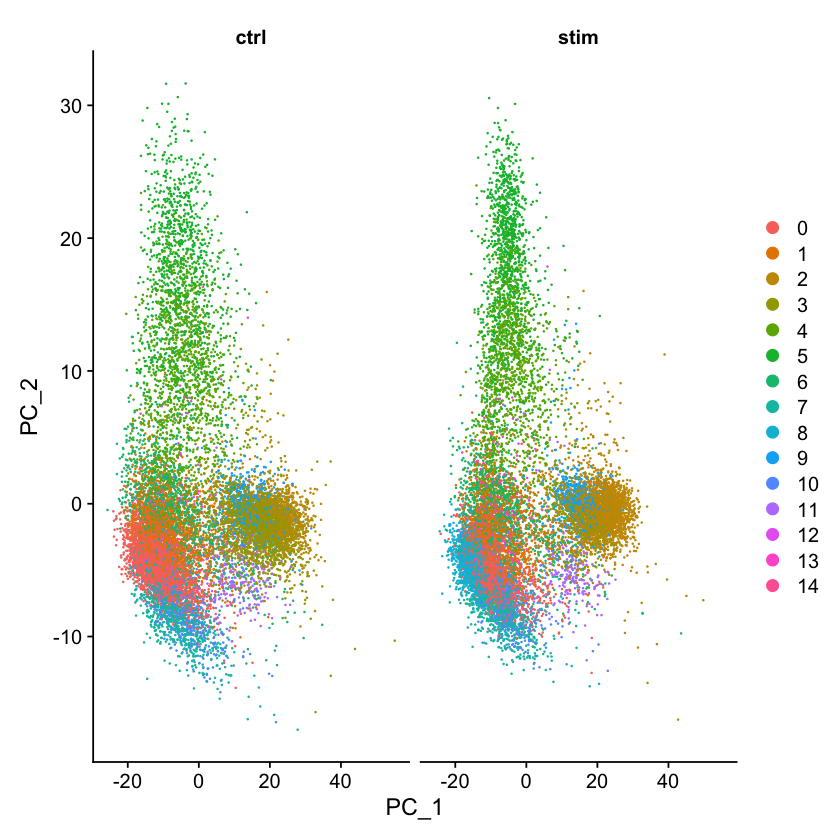

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29629
Number of edges: 1085422

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9187
Number of communities: 15
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29629
Number of edges: 1085422

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9007
Number of communities: 17
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29629
Number of edges: 1085422

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8850
Number of communities: 20
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29629
Number of edges: 1085422

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8728
Number of communities: 23
Elapsed time: 3 seconds
Modulari

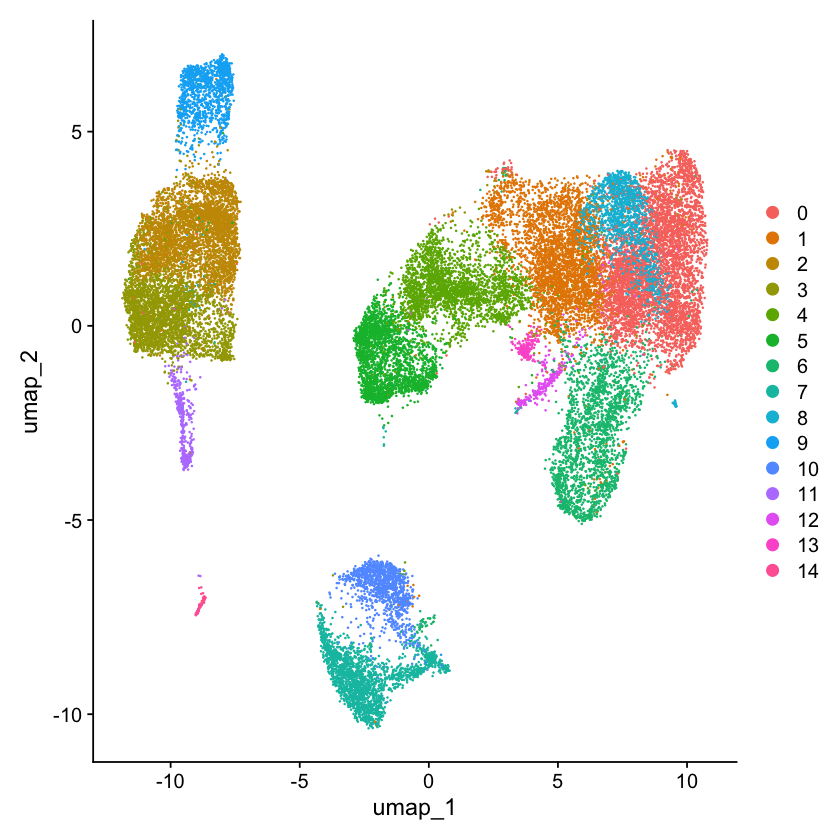

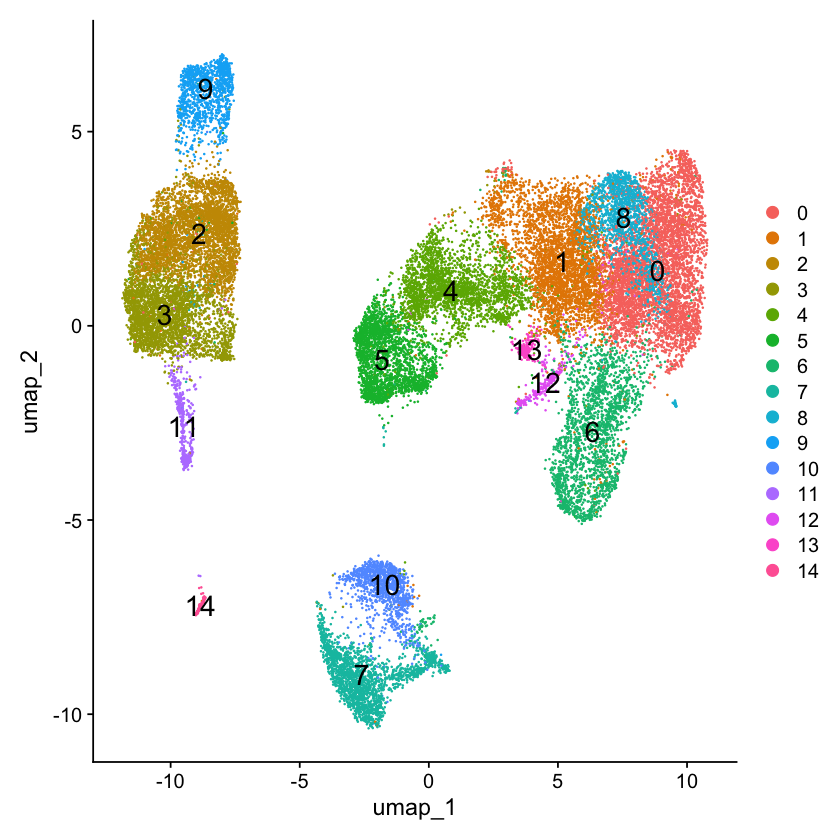

In [44]:
# Run PCA
seurat_integrated <- RunPCA(object = seurat_integrated)

# Plot PCA
PCAPlot(seurat_integrated,
        split.by = "sample")

# Set seed
set.seed(123456)

# Run UMAP
seurat_integrated <- RunUMAP(seurat_integrated, 
                             dims = 1:40,
			                 reduction = "pca")

# Plot UMAP                             
DimPlot(seurat_integrated)

# Determine the K-nearest neighbor graph
seurat_integrated <- FindNeighbors(object = seurat_integrated, 
                                dims = 1:40)

# Determine the clusters for various resolutions                                
seurat_integrated <- FindClusters(object = seurat_integrated,
                               resolution = c(0.4, 0.6, 0.8, 1.0, 1.4))

# Assign identity of clusters
Idents(object = seurat_integrated) <- "integrated_snn_res.0.4"

# Plot the UMAP
DimPlot(seurat_integrated,
        reduction = "umap",
        label = TRUE,
        label.size = 6)